<a href="https://colab.research.google.com/github/NicholasChoong/natural-language-processing/blob/main/lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab11


In this lab, we will try to play with the [Stanford Alpaca](https://github.com/tatsu-lab/stanford_alpaca), which is fine-tuned from a 7B [LLaMA](https://arxiv.org/pdf/2302.13971.pdf) model on 52K instruction-following data. Let's have a look at how it works, simply with the pytorch transformer libraries!

# Setup

First, let's prepare and install the required packages.

In [ ]:
!pip install bitsandbytes
!pip install -q datasets loralib sentencepiece
!pip install -q git+https://github.com/zphang/transformers@c3dc391
!pip install -q git+https://github.com/huggingface/peft.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
  Installing b

# Load Model

In [ ]:

from peft import PeftModel
from transformers import LLaMATokenizer, LLaMAForCausalLM, GenerationConfig

# Load the LLaMA tokenizer
# Warning: running takes some time!
tokenizer = LLaMATokenizer.from_pretrained("decapoda-research/llama-7b-hf")

# Load the pretrained LLaMA-7B model
model = LLaMAForCausalLM.from_pretrained(
    "decapoda-research/llama-7b-hf",
    load_in_8bit=True,
    device_map="auto",
)

# Load the Alpaca model -> we will use it for generating answers following the input instructions
model = PeftModel.from_pretrained(model, "tloen/alpaca-lora-7b")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

# Instructions-based Generation

In [ ]:
# Function for preparing the prompt
def generate_prompt(instruction, input=None):
    if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

                ### Instruction:
                {instruction}

                ### Input:
                {input}

                ### Response:"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

                ### Instruction:
                {instruction}

                ### Response:"""

In [ ]:
# Configuration for answer generation
generation_config = GenerationConfig(
    num_beams=4,
)

def evaluate(instruction, input=None):
    prompt = generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=256
    )
    clean_output=""
    for s in generation_output.sequences:
        output = tokenizer.decode(s)
        clean_output = output.split("### Response:")[1].strip()
        print("Response:", clean_output)
    return clean_output

We can just run the evaluate() function and input any instruction or prompt in the pop-up input field. Let's try running the following code and input the instruction of "`Please paraphrase the following paragraph: The University of Western Australia is a public research university in the Australian state of Western Australia. The university's main campus is in Perth, the state capital, with a secondary campus in Albany and various other facilities elsewhere.`" (You can just copy-paste the text into the pop-up input field after you run the code).

In [ ]:
evaluate(input("Instruction: "))

Response: The University of Western Australia is a public research university located in the Australian state of Western Australia. Its main campus is in Perth, the state capital, with a secondary campus in Albany and various other facilities throughout the state.


'The University of Western Australia is a public research university located in the Australian state of Western Australia. Its main campus is in Perth, the state capital, with a secondary campus in Albany and various other facilities throughout the state.'

Let's try to generate some code snipets, using the prompt: "`Please generate a python function that can return a random number between 0 and 100.`". Note: the generated answer may not be correct.

In [ ]:
evaluate(input("Instruction: "))

Instruction: Please generate a python function that can return a random number between 0 and 100.
Response: def random_number():
                    return random.randint(0, 100)


'def random_number():\n                    return random.randint(0, 100)'

# Lab 11 Exercise 
Please complete the following **question E1** for Lab 11 and check with your Tutor (Lab Facilitator) in the lab. 

**Submission Due**: 02/06/2023 9PM


## E1. Let's evaluate the Alpaca translation!


So far, we already know how to utilize the prompt/instruction to ask the Alpaca model to generate the answer for us. We can do the same for the translation task! In this exercise, you are asked to evaluate the Alpaca translation result based on the BLUE score. You can find the instructions for how to calculate the bleu score in the BLEU score calculator section in the end. 

Assume we have a sentence in Chinese: "我这学期修了自然语言处理这门课", below is the translation from Google translator to help you understand what it means.

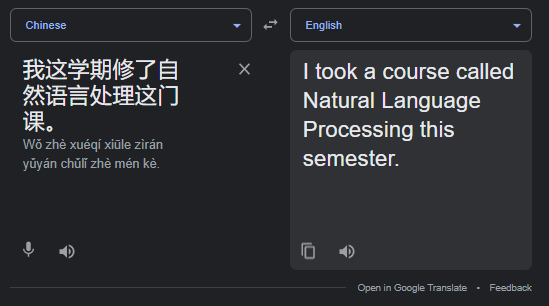

Now, please utilize the Alpaca model we've been practising in the sample code above to **translate this Chinese sentence into English, via the prompt**. Then, based on the generated result (i.e., the English translation), you need to calculate the BLUE score given the following 5 references:




*   This semester I took a course in natural language processing
*   I have completed a course on natural language processing this semester
*   I studied a course on natural language processing in this semester
*   I pursued a course in natural language processing during this semester
*   I undertook a course on natural language processing for this semester








In [ ]:
# 1. Translate the given Chinese sentence into English
# Chinese sentence: 我这学期修了自然语言处理这门课
hypothesis = evaluate("Instruction: Please translate into English: 我这学期修了自然语言处理这门课").split()
print(hypothesis)

Response: I completed the Natural Language Processing course this semester.
['I', 'completed', 'the', 'Natural', 'Language', 'Processing', 'course', 'this', 'semester.']


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# 2. Calculate the BLEU score using the provided references

reference = [
    "This semester I took a course in natural language processing".split(),
    "I have completed a course on natural language processing this semester".split(),
    "I studied a course on natural language processing in this semester".split(),
    "I pursued a course in natural language processing during this semester".split(),
    "I undertook a course on natural language processing for this semester".split()
]

print('BLEU score -> {}'.format(sentence_bleu(reference, hypothesis)))

BLEU score -> 1.331091014027761e-231


## BLEU score calculator


BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text. Though originally designed for only translation models, it is now used for other natural language processing applications as well. 

Specifically, BLUE score compares a sentence (hypothesis) against one or more reference sentences and tells how well does the candidate sentence matched the list of reference sentences. It gives an output score between 0 and 1. A BLEU score of 1 means that the candidate sentence perfectly matches one of the reference sentences.

In the following section, we will utilize the [sentence_bleu()](https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.sentence_bleu) function from the nltk library for easy calculation.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# Assume we have the following 4 sentences as our references
# Note that each of them are a list of words (tokenzied)
reference = [
    'this is a yellow dog'.split(),
    'it is a big and old dog'.split(),
    'a dog it is'.split(),
    'a big dog, it is'.split() 
]


In [ ]:
# Now we can call the sentence_bleu() function to calculate the score.
# Assume we have our hypothesis:
hypothesis = 'it is a big dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, hypothesis)))

In this exercise, you are asked to build an translation interface, utilizing the ktrain **Translator** (introduced in the section 2.2 above). The interface is provided below. It allows users to input the `English_Query` and the `Target_Language`. You need to implemente the Translator, which will take the english query as input, and translate it to the target language. After users input the query and target language, and run the cell, the translation will be shown in the output.


**Note** that it should allow the translation for ALL three target languages, including Chinese, Spanish, and Arabic. 

Hint: You can easily find the models that can do the traslations from the [Helsinki-NLP](https://huggingface.co/models?search=Helsinki-NLP%2Fopus-mt).

## Sample Input/Output

Sample output for the translation:

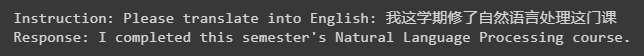

Sample output for the BLEU score calculation:

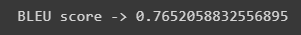